# MobileNet

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

print("tensor flow version : " + tf.__version__)

Num GPUs Available:  0
tensor flow version : 2.0.0


## Fine-tune MobileNet on cats and dogs

### Image preparation

The images included in the data/cats-and-dogs directory are a random subset of the full cat and dog data set from the following Kaggle competition: https://www.kaggle.com/c/dogs-vs-cats/data

In [3]:
train_path = './data/cats-and-dogs/train'
valid_path = './data/cats-and-dogs/valid'
test_path = './data/cats-and-dogs/test'

In [4]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [5]:
print(train_batches.n)
print(valid_batches.n)
print(test_batches.n)

1000
200
100


In [6]:
# assert train_batches.n == 40
# assert valid_batches.n == 16
# assert test_batches.n == 10
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

### Modify Model

In [7]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [8]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [9]:
def count_params(model):
    non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.non_trainable_weights])
    trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_weights])
    return {'non_trainable_params': non_trainable_params, 'trainable_params': trainable_params}

In [10]:
params = count_params(mobile)
assert params['non_trainable_params'] == 21888
assert params['trainable_params'] == 4231976

In [11]:
x = mobile.layers[-6].output
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=predictions)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [13]:
params = count_params(model)
assert params['non_trainable_params'] == 21888
assert params['trainable_params'] == 3209026

In [14]:
for layer in model.layers[:-5]:
    layer.trainable = False

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [16]:
params = count_params(model)
assert params['non_trainable_params'] == 2178240
assert params['trainable_params'] == 1052674

In [17]:
valid_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int32)

### Train the model

In [18]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
history = model.fit(x=train_batches, steps_per_epoch=4, validation_data=valid_batches, validation_steps=2, epochs=30, verbose=2)

Train for 4 steps, validate for 2 steps
Epoch 1/30
4/4 - 7s - loss: 0.6682 - accuracy: 0.7000 - val_loss: 0.6684 - val_accuracy: 0.6000
Epoch 2/30
4/4 - 4s - loss: 0.4071 - accuracy: 0.8000 - val_loss: 0.8282 - val_accuracy: 0.5000
Epoch 3/30
4/4 - 4s - loss: 0.3396 - accuracy: 0.8750 - val_loss: 1.0044 - val_accuracy: 0.5000
Epoch 4/30
4/4 - 4s - loss: 0.3013 - accuracy: 0.8250 - val_loss: 1.1368 - val_accuracy: 0.5500
Epoch 5/30
4/4 - 4s - loss: 0.2529 - accuracy: 0.9250 - val_loss: 1.2241 - val_accuracy: 0.5500
Epoch 6/30
4/4 - 3s - loss: 0.1773 - accuracy: 0.9500 - val_loss: 1.1952 - val_accuracy: 0.6000
Epoch 7/30
4/4 - 4s - loss: 0.1245 - accuracy: 0.9500 - val_loss: 1.1497 - val_accuracy: 0.6000
Epoch 8/30
4/4 - 4s - loss: 0.1200 - accuracy: 0.9250 - val_loss: 1.0864 - val_accuracy: 0.6000
Epoch 9/30
4/4 - 4s - loss: 0.0879 - accuracy: 0.9500 - val_loss: 1.0284 - val_accuracy: 0.6500
Epoch 10/30
4/4 - 4s - loss: 0.0961 - accuracy: 0.9750 - val_loss: 0.9696 - val_accuracy: 0.6500

In [20]:
assert model.history.history.get('accuracy')[-1] > 0.95

### Predict cats and dogs

In [21]:
test_labels = test_batches.classes

In [22]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [23]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

In [24]:
predictions = model.predict(x=test_batches, steps=10, verbose=0)

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
#rounded_predictions = np.argmax(predictions, axis=-1)
#cm = confusion_matrix(y_true=test_labels, y_pred=rounded_predictions)
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

# cm = confusion_matrix(y_true=test_labels, y_pred=np.round(predictions[:,0]))

In [27]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[50  0]
 [ 5 45]]


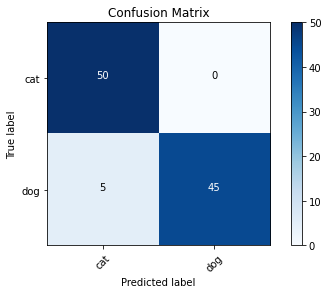

In [28]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [29]:
assert np.sum(test_labels == predictions.argmax(axis=1)) > 8

In [30]:
def print_results(cm):
    tp = cm[0, 0]
    tn = cm[1, 1]
    fn = cm[0, 1]
    fp = cm[1, 0]
    
    accuracy = ((tp + tn) / (tp + tn + fp + fn)) * 100
    
    sensitivity = (tp / (tp + fn)) * 100
    
    specificity = (tn / ( tn + fp )) * 100
    
    print ('Accuracy: ',  accuracy)

    print ('Sensitivity: ', sensitivity)
    
    print ('Specificity: ',  specificity)

In [31]:
print_results(cm)

Accuracy:  95.0
Sensitivity:  100.0
Specificity:  90.0


In [32]:
def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.figure()
    
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    
    plt.show()

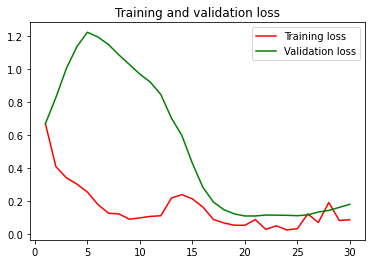

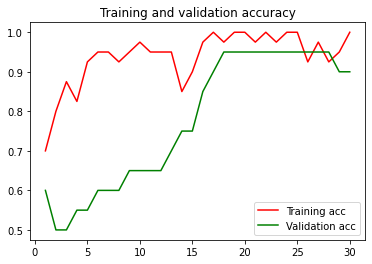

<Figure size 432x288 with 0 Axes>

In [33]:
plot_training_curves(history)

In [34]:
# # export model
# import pickle

# pickle.dump(model, open('./mobilenet.pkl', 'wb'))

In [35]:
MODEL_FILEPATH= '../models/mobilenet_model.h5'
# Save model
if os.path.isfile(MODEL_FILEPATH) is False:
    model.save(MODEL_FILEPATH)